In [1]:
def save_model(models, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(models, handle)
        
def load_model(filename):
    with open(filename, 'rb') as handle:
        model = pickle.load(handle)
    return model    
        
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)
    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

def lgb_trainer(X, y, params, n_folds):
    skf = StratifiedKFold(n_splits=n_folds)
    models = []
    for train_idx, test_idx in tqdm(skf.split(X.values, y.values)):
            gc.collect()
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_tr, y_tr = augment(X_train.values, y_train.values)
            X_tr = pd.DataFrame(X_tr)
            trn_data = lgb.Dataset(X_tr, label=y_tr)
            test_data = lgb.Dataset(X.values[test_idx], label=y.values[test_idx])
            model_lgb     = lgb.train(params, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
            models.append(model_lgb)
            auc = roc_auc_score(y.values[test_idx], model_lgb.predict(X.values[test_idx]))
    return models

def lgb_trainer_no_aug(X, y, params, n_folds):
    skf = StratifiedKFold(n_splits=n_folds)
    models = []
    for train_idx, test_idx in tqdm(skf.split(X.values, y.values)):
            gc.collect()
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_tr, y_tr = X_train.values, y_train.values
            X_tr = pd.DataFrame(X_tr)
            trn_data = lgb.Dataset(X_tr, label=y_tr)
            test_data = lgb.Dataset(X.values[test_idx], label=y.values[test_idx])
            model_lgb     = lgb.train(params, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
            models.append(model_lgb)
            auc = roc_auc_score(y.values[test_idx], model_lgb.predict(X.values[test_idx]))
    return models

def lgb_trainer_for_bayesian_optim(X, y, params):
        X_tr, X_val, y_tr, y_val  = train_test_split(X, y, test_size = 0.2, random_state=42)    
        trn_data = lgb.Dataset(X_tr, label=y_tr)
        test_data = lgb.Dataset(X_val, label=y_val)
        model_lgb     = lgb.train(params, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
        auc = roc_auc_score(y_val, model_lgb.predict(X_val))
        return auc

def test_f(X, y, models):
    preds = pd.DataFrame({})
    for i, model in enumerate(models):
        preds[str(i)] = model.predict(X)
        print(f"Fold: {i} \t Score: {roc_auc_score(y, preds[str(i)].values)}")
    averaged_preds = preds.mean(axis=1)
    scorre = roc_auc_score(y, averaged_preds)
    print(f"Score: {scorre}")
    return scorre, averaged_preds, preds

def augment_uniques(data):
    maps = {}
    for feature in tqdm(data.columns):
        if feature in ['ID_code', 'target']:
            continue
        a, b = np.unique(data[feature], return_counts=True)
        unique_map = dict(zip(a, b))
        maps[feature] = unique_map
        data[f'count_{feature}'] = data[feature].map(unique_map)
    return data, maps  

def answer_agument(testdf, maps):
    for feature in tqdm(testdf.columns):
        if feature in ['ID_code']:
            continue
        testdf[f'count_{feature}'] = testdf[feature].map(maps[feature])    
    return testdf    


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import pickle
import gc
import seaborn as sns
import scikitplot as skplt
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")
ANSWERX = 'MakeAnswersFromThis.csv'
X = 'finalX.csv'
y = 'finalY.csv'

# Stupidity

In [2]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)
whole = train.append(test)

In [5]:
whole, unique_map = augment_uniques(whole)

In [6]:
traindf, testdf = whole[:200000], whole[200000:]
y = traindf.target
X = traindf.drop(['target', 'ID_code'], axis=1)

In [7]:
ATEST = 'data/test.csv'
test = pd.read_csv(ATEST)
dftest = answer_agument(test, unique_map)

In [9]:
dftest.to_csv('MakeAnswersFromThis.csv', index=False)

In [12]:
X.to_csv('finalX.csv', index=False)

In [14]:
y.to_csv('finalY.csv', index=False)

# Stacking

In [4]:
X = pd.read_csv(X)
y = pd.read_csv(y)

In [5]:
X.head()

,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,...,count_var_90,count_var_91,count_var_92,count_var_93,count_var_94,count_var_95,count_var_96,count_var_97,count_var_98,count_var_99
0,8.9255,-6.7863,2.9252,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,...,1,51,3,18,3,20,2,1,14,4
1,11.5006,-4.1473,-0.4032,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,...,1,77,3,24,4,3,1,2,15,5
2,8.6093,-2.7457,-0.3249,-0.3939,12.6317,14.8863,1.3854,15.0284,3.9995,5.3683,...,1,72,6,26,6,17,2,1,22,8
3,11.0604,-2.1518,2.3061,-19.8592,22.5316,18.6129,1.3512,9.3291,4.2835,10.3907,...,1,62,2,24,1,4,3,1,9,3
4,9.8369,-1.4834,-9.4458,-22.9264,12.3562,17.3410,1.6940,7.1179,5.1934,8.8230,...,1,65,3,16,2,18,1,1,15,3


In [9]:
def get_df(models_list, X):
    i = 0
    df_dict = {}
    for models in tqdm(models_list):
        models = load_model(models)
        for model in tqdm(models):
            i += 1
            key = f"col_{i}"
            df_dict[key] = model.predict(X)
    return pd.DataFrame(df_dict)        

In [10]:
models = "ovvverrr.m ovvverrrx2.m ovvverrrx3.m ovvverrrx4.m".split()
Xstack = get_df(models, X)

In [11]:
Xstack.to_csv('Xstack.csv', index=False)

In [ ]:
dftest = pd.read_csv('MakeAnswersFromThis.csv')
dftest.rename(columns=lambda x: 'z' + str(x) if x[0] == 'c' else x, inplace=True)
kek= dftest.reindex(sorted(dftest.columns), axis=1)

In [22]:
adfstack = get_df(models, kek.drop(['ID_code'], axis=1))

In [23]:
adfstack.to_csv('adfstack.csv', index=False)

# Let the stacking begin

In [4]:
final_test = pd.read_csv('adfstack.csv')

In [9]:
X = pd.read_csv('Xstack.csv')

In [52]:
print(f"{X.shape} | {final_test.shape} | {y.shape}")

(200000, 40) | (200000, 40) | (200000, 1)


In [46]:
y = pd.read_csv('finalY.csv')

In [48]:
y.rename(columns=lambda x:'y', inplace=True )
y.loc[-1] = 0.0
y.index += 1

# Bayesian search

In [51]:
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV

In [53]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, output_process=False):
    # prepare data
#     Xtr, Xval, ytr, yval  = train_test_split(X, y, test_size = 0.2, random_state=42)
#     train_data = lgb.Dataset(data=Xtr, label=ytr, free_raw_data=False)
#     val_data = lgb.Dataset(data=Xval, label=yval, free_raw_data=False)

    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, learning_rate, num_threads, min_data_in_leaf, min_sum_hessian_in_leaf, reg_alpha, reg_lambda):
        # fixed parameters
        params = {'application':'binary',
                  'num_iterations': n_estimators,
                  'learning_rate':learning_rate,
                  'early_stopping_round':100,
                  'metric':'auc',
                  'max_depth':-1,
                  'bagging_freq':7,
                  'verbosity':-1}
        # variables
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['learning_rate'] = learning_rate
        params['num_threads'] = int(num_threads)
        params['min_data_in_leaf'] = int(min_data_in_leaf)
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['reg_alpha'] = max(min(reg_alpha, 1), 0)
        params['reg_lambda'] = max(min(reg_lambda, 1), 0)
        
        score = lgb_trainer_for_bayesian_optim(X, y, params)
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        
        return score
    # range of variables
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (5, 40),
                                            'feature_fraction': (0.01, 0.9),
                                            'bagging_fraction': (0.8, 0.1),
                                            'learning_rate': (0.001, 0.01),
                                            'num_threads': (6, 10),
                                            'min_data_in_leaf': (60, 200),
                                            'min_sum_hessian_in_leaf': (5.0 , 15.0),
                                            'reg_alpha': (0.0 , 1.0),
                                            'reg_lambda': (0.0 , 1.0),
                                           },
                                             random_state=42)
    # optimize!
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res

opt_params = bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=42, n_estimators=100) 

|   iter    |  target   | baggin... | featur... | learni... | min_da... | min_su... | num_le... | num_th... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.564487	valid_1's auc: 0.500683
|  1        |  0.5007   |  0.5378   |  0.8561   |  0.007588 |  143.8    |  6.56     |  10.46    |  6.232    |  0.8662   |  0.6011   |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557723	valid_1's auc: 0.502136
|  2        |  0.5021   |  0.3043   |  0.02832  |  0.009729 |  176.5    |  7.123    |  11.36    |  6.734    |  0.3042   |  0.5248   |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc:

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[97]	training's auc: 0.650741	valid_1's auc: 0.501416
|  22       |  0.5014   |  0.8      |  0.1508   |  0.004867 |  198.5    |  14.63    |  36.97    |  7.29     |  0.9188   |  0.6807   |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.676347	valid_1's auc: 0.50331
|  23       |  0.5033   |  0.8      |  0.5493   |  0.004028 |  60.88    |  5.183    |  39.81    |  8.606    |  0.6437   |  0.01046  |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.66808	valid_1's auc: 0.501472
|  24       |  0.5015   |  0.8      |  0.1168   |  0.006785 |  60.34    |  5.236    |  39.71    |  9.911    |  0.7693   |  0.2853   |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iterati

In [55]:
opt_params[35]

{'target': 0.5069993743091272,
 'params': {'bagging_fraction': 0.8,
  'feature_fraction': 0.6409129751307899,
  'learning_rate': 0.004444183166341189,
  'min_data_in_leaf': 61.12700472473412,
  'min_sum_hessian_in_leaf': 5.477195782834263,
  'num_leaves': 39.80431753787029,
  'num_threads': 6.977054472760379,
  'reg_alpha': 0.5713746629098466,
  'reg_lambda': 0.7659697399878922}}

# Train

In [56]:
Xtr, Xval, ytr, yval  = train_test_split(X, y, test_size = 0.2, random_state=42)

In [59]:
param = {
   'bagging_fraction': 0.8,
  'feature_fraction': 0.6409129751307899,
  'learning_rate': 0.004444183166341189,
  'min_data_in_leaf': 61,
  'min_sum_hessian_in_leaf': 5.477195782834263,
  'num_leaves': 39,
  'num_threads': 7,
  'reg_alpha': 0.5713746629098466,
  'reg_lambda': 0.7659697399878922,
    'boost': 'gbdt',
    'metric':'auc',
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'seed':42,
}


#^best

In [81]:
rank_models = lgb_trainer_no_aug(Xtr, pd.Series(ytr.values[:,0]), param, n_folds = 5)

Training until validation scores don't improve for 4000 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.537037	valid_1's auc: 0.503822
Training until validation scores don't improve for 4000 rounds.
Early stopping, best iteration is:
[28]	training's auc: 0.58447	valid_1's auc: 0.501803
Training until validation scores don't improve for 4000 rounds.
Early stopping, best iteration is:
[44]	training's auc: 0.594663	valid_1's auc: 0.505405
Training until validation scores don't improve for 4000 rounds.
Early stopping, best iteration is:
[7]	training's auc: 0.55323	valid_1's auc: 0.509027
Training until validation scores don't improve for 4000 rounds.
Early stopping, best iteration is:
[13]	training's auc: 0.593732	valid_1's auc: 0.502715


In [83]:
scorre, q, w = test_f(Xval, yval, rank_models)

Fold: 0 	 Score: 0.5017701249486
Fold: 1 	 Score: 0.4995392315914421
Fold: 2 	 Score: 0.5055092692410392
Fold: 3 	 Score: 0.5023224748657927
Fold: 4 	 Score: 0.5004523109329986
Score: 0.5050976123548913


# asdasd

In [86]:
final_test = pd.read_csv('adfstack.csv')

In [92]:
submission = pd.read_csv('answer_1_simple_gbm.csv')
submission.head()

,ID_code,target
0,test_0,0.103566
1,test_1,0.207013
2,test_2,0.157158
3,test_3,0.188586
4,test_4,0.045161


In [93]:
submission.target = final_test.mean(axis=1)

In [95]:
submission.to_csv('#a1.csv', index=False)
submission.head()


,ID_code,target
0,test_0,0.044425
1,test_1,0.129835
2,test_2,0.151489
3,test_3,0.174534
4,test_4,0.053164


# cOrr

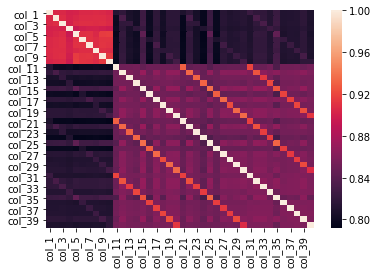

In [109]:
corr = final_test.corr(method='kendall')
sns.heatmap(corr)

In [111]:
weights = corr.sum(axis=1)

In [125]:
w = []
for col in weights.index:
    we = 1 / (weights[col] ** 3)
    w.append(we)

In [132]:
submission.target = np.average(final_test, weights=w, axis=1)

In [134]:
submission.to_csv('#a2.csv', index=False)
submission

,ID_code,target
0,test_0,0.044391
1,test_1,0.129663
2,test_2,0.151100
3,test_3,0.175111
4,test_4,0.053089
5,test_5,0.000848
6,test_6,0.003232
7,test_7,0.069774
8,test_8,0.000885
9,test_9,0.003975
